In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../csv/full_descriptor_dataset.csv')
df

,name,melodic,rhythmic,energetic,apathetic,raw,surreal,anxious,bittersweet,warm,...,acoustic,sentimental,angry,spiritual,sad,happy,epic,minimalistic,futuristic,natural
0,Living in Darkness,1,1,1,0,1,0,1,0,0,...,0,0,1,0,2,0,0,0,0,0
1,Souvenirs d'un autre monde,1,0,0,0,0,1,0,1,1,...,0,2,0,1,1,0,0,0,0,2
2,People Who Can Eat People Are the Luckiest Peo...,1,0,2,0,1,0,1,1,0,...,1,1,0,0,3,1,0,0,0,0
3,Funeral,1,0,0,0,0,1,1,2,0,...,0,2,0,0,1,2,1,0,0,1
4,Neon Bible,1,0,0,0,0,1,1,0,0,...,0,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,In the Aeroplane Over the Sea,1,0,0,0,2,2,0,2,1,...,1,2,0,0,2,0,0,0,0,1
445,McCartney,1,0,0,0,2,0,0,1,1,...,0,0,0,0,1,1,0,1,0,0
446,Hail to the Thief,1,1,1,0,0,1,1,0,0,...,0,1,1,0,3,0,0,0,0,1
447,Wish You Were Here,1,0,0,0,0,1,0,2,0,...,0,1,0,0,2,0,1,0,0,0


In [3]:
df.drop('name', axis=1, inplace=True)

## Data transformations before training

Before getting to this point, many ideas were tested and discarded, as can be seen on "../Discarded_Notebooks". Many complex and arbitrary modeling strategies proved to be ineffective, but also served the purpose of understanding how our data behaves and is distributed inside the vector space, and how it affects k-Means Clustering's performance. So I encourage that you also take a look there if you're curious, especially notebooks "04_Further_Data_Modeling" and "05_Explorig_Data_Distributions".

One of the main finding in these notebooks was that the presence of binary features disrupts k-Means functioning at the early stages of the algorithm (https://www.ibm.com/support/pages/clustering-binary-data-k-means-should-be-avoided), so we need to apply some transformation that keeps as much information and variance as possible, while breaking the inconvenient structure of binary features. One way to do that is to use Principal Component Analysis.

In [4]:
variances_df = df.var()
variances_sorted = variances_df.sort_values(ascending=False)
variances_sorted

noisy           2.489063
sad             2.178522
calm            1.320285
progressive     1.098145
dark            1.092855
humorous        0.930341
surreal         0.801911
happy           0.754057
bittersweet     0.560770
cold            0.538220
energetic       0.526855
warm            0.464783
raw             0.428770
spiritual       0.427329
sentimental     0.419195
mysterious      0.353892
angry           0.347667
natural         0.337486
minimalistic    0.289194
urban           0.280365
rhythmic        0.248260
anxious         0.244641
poetic          0.229876
melodic         0.227907
quirky          0.223701
atmospheric     0.222220
eclectic        0.219138
romantic        0.215002
rebellious      0.207097
dense           0.173501
apathetic       0.166839
anthemic        0.143861
futuristic      0.143822
heavy           0.112741
epic            0.097439
serious         0.079492
pastoral        0.075783
acoustic        0.070146
dtype: float64

Leaving the Linear Algebra-heavy concepts aside, Principal Component Analysis consists of, basically, transforming our original features into new ordered features called "Principal Components", which are not much more than a linear combination of the original features. The "ordered" part is relevant, because components are ordered by the dataset variance each one holds.

The idea is that, as Principal Component 1 is made of a linear combination of all features, it can grasp a bit of information from all features, and by doing so it has a higher variance than for example 'noisy', which is the feature with highest variance from the original dataset.

Doing this will have 2 major effects in the algorithm:

    1) Dimensionality reduction: an X number of PCs will have higher variance than the same X number of original features, by using PCs as features we can have a smaller number of dimensions while maintaining a certain percentage of variance that we judge enough for training. PCA actually allows us to have as many PCs as we have original features, but then dimensionality reduction doesn't happen, and the transformation loses its purpose. More on why dimensionality reduction is important can be found in notebook "02_Data_Modeling.ipynb";
    
    2) Breaking the evenly-spaced structures found in binary features: since principal components are made of linear combinations of many features, even if they are all binary, their linear combination won't be.




In [5]:
# Normalizing features before using PCA, since a lot of them aren't binary, and as such, are in different scales
from sklearn.preprocessing import StandardScaler
X = df.to_numpy()
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# Transforming data with PCA. At first, only to analyse how many PCs we need for preserving 90% of the dataset variance
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)
pca_ = pca.transform(X)

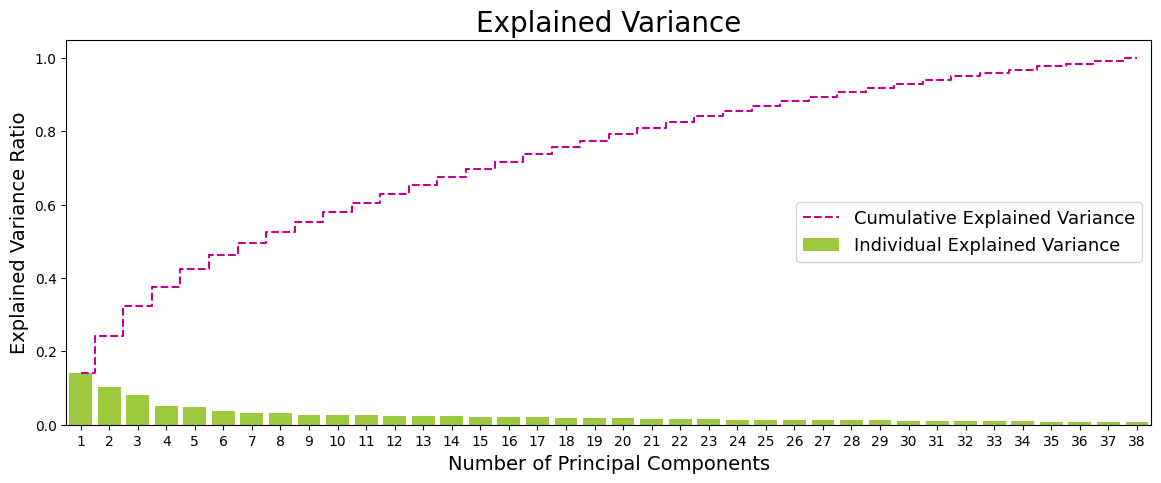

In [6]:
"Cell code source: https://www.kaggle.com/code/beyzanks/principal-component-analysis-pca-rf-knn/notebook"
fig, ax = plt.subplots(figsize=(14, 5))
plt.plot(range(X.shape[1]), pca.explained_variance_ratio_.cumsum(), linestyle='--', drawstyle='steps-mid', color='#c4008f', label='Cumulative Explained Variance')
sns.barplot(x=np.arange(1,X.shape[1]+1), y=pca.explained_variance_ratio_, alpha=0.85, color='#96db01', label='Individual Explained Variance')
plt.ylabel('Explained Variance Ratio', fontsize = 14)
plt.xlabel('Number of Principal Components', fontsize = 14)
ax.set_title('Explained Variance', fontsize = 20)
plt.legend(loc='center right', fontsize = 13)

In [7]:
for i in range(1, 39):
    ratioSum = pca.explained_variance_ratio_[:i].sum()
    print(f'{i} PCs: {ratioSum:.2f}%')

1 PCs: 0.14%
2 PCs: 0.24%
3 PCs: 0.32%
4 PCs: 0.37%
5 PCs: 0.42%
6 PCs: 0.46%
7 PCs: 0.49%
8 PCs: 0.53%
9 PCs: 0.55%
10 PCs: 0.58%
11 PCs: 0.61%
12 PCs: 0.63%
13 PCs: 0.65%
14 PCs: 0.68%
15 PCs: 0.70%
16 PCs: 0.72%
17 PCs: 0.74%
18 PCs: 0.76%
19 PCs: 0.78%
20 PCs: 0.79%
21 PCs: 0.81%
22 PCs: 0.83%
23 PCs: 0.84%
24 PCs: 0.85%
25 PCs: 0.87%
26 PCs: 0.88%
27 PCs: 0.89%
28 PCs: 0.91%
29 PCs: 0.92%
30 PCs: 0.93%
31 PCs: 0.94%
32 PCs: 0.95%
33 PCs: 0.96%
34 PCs: 0.97%
35 PCs: 0.98%
36 PCs: 0.99%
37 PCs: 0.99%
38 PCs: 1.00%


As seen above, if we want to preserve >90% of the dataset variance, we can use the first 28 PCs.

In [9]:
pca = PCA(28)
pca.fit(X)
pca_ = pca.transform(X)

During the developments in "../Discarded_Notebooks", it could be observed that sound-based music description is an immensely diversified space. Hence a very high number of clusters will be needed for the clusters to make sense. After some testing, they start to see more consistency around clusterNum = 25 and onwards.

In [18]:
from sklearn.cluster import KMeans
clusterNum = 25
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(pca_)
labels = k_means.labels_
df['labels'] = k_means.labels_

named_df = pd.read_csv('../csv/full_descriptor_dataset.csv')
merged_df = pd.merge(df['labels'], named_df[['name']], left_index=True, right_index=True)

label_name_list = merged_df.groupby('labels')['name'].apply(list)

with open('../Outputs/final_output.txt', 'w', encoding='utf-8') as file:
    for label, names in label_name_list.items():
        file.write(f"{label}: {', '.join(names)}\n")
        file.write(f"\n")

Since we're dealing with unsupervised learning, it isn't as easy to measure the accuracy of our model. It's also hard for people who haven't heard these specific albums to judge how good the clustering is. What I can do is offer my personal opinion since these albums compose my personal listening history.

This last clustering is more accurate than all others generated by "../Discarded_Notebooks/07A_kMeansClustering_with_Subsets", and much more accurate than the one generated by "../Discarded_Notebooks/07B_DBSCAN", which wasn't a good match for the way we were framing our problem.

At clusterNum = 25, we still get a lot of clustering with instances that are pretty mixed, and more rarely a highly cohesive group of instances that are separated in different clusters (i.e.: albums from clusters 4 and 23). However, lowering the clusterNum in order to group these instances below the same label can't seem to be done without also increasing the "uncohesiveness" of other clusters. Increasing clusterNum has the opposite effect.

Clusters with great consistency in this output: 0, 4, 13, 16, 20, 23.